In [1]:
import numpy as np
import pprint, json
wGreenNeuron = np.array([1.73673761, 1.89791391, -2.10677342, -0.14891209, 0.58306155])
wOrangeNeuron = np.array([-2.25923303, 0.13723954, -0.70121322, -0.62078008, -0.47961976])
wOutputNeuron = np.array([1.20973877, -1.07518386, 0.80691921, -0.29078347, -0.22094764, -0.16915604,
    1.10083444, 0.08251052, -0.00437558, -1.72255825, 1.05755642, -2.51791281, -1.91064012])

X = np.array([
    [0, 0, 0.8, 0.4, 0.4, 0.1, 0, 0, 0],
    [0, 0.3, 0.3, 0.8, 0.3, 0, 0, 0, 0],
    [0, 0, 0, 0, 0.3, 0.3, 0.8, 0.3, 0],
    [0, 0, 0, 0, 0, 0.8, 0.4, 0.4, 0.1],
    [0.8, 0.4, 0.4, 0.1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0.3, 0.3, 0.8, 0.3],
])

y = np.array([-1, 1, 1, -1, -1, 1])

## Forward pass

In [2]:
def shared_layer(w, n):
    nW = w.shape[0] - 1 # number of weights (excluding bias) in the layer
    forward = lambda s: np.tanh(np.dot(w, np.append(s, 1.0)))
    return lambda x: np.array([forward(x[i: i+nW]) for i in range(n)])

layerGreen = shared_layer(wGreenNeuron, 6)
layerOrange = shared_layer(wOrangeNeuron, 6)
layerOutput = lambda alpha, beta: np.tanh(np.dot(wOutputNeuron, np.append(np.concatenate((alpha, beta)), 1.0) ))
model = lambda x: layerOutput(layerGreen(x), layerOrange(x))

In [3]:
for i in range(len(X)):
    print(model(X[i]))

-0.986291504725
-0.195753705897
-0.136352627781
0.796901504738
-0.717043083584
0.62556537677


## Backward pass

**Output layer**

$$
\delta^H = \frac{\partial E}{\partial \nu^H} = -2 e (1-(y^H)^2)
$$

$$
\Delta w_{i}^H = -\alpha \delta^H y_i^{H-1}
$$

$$
\Delta b^H = -\alpha \delta^H
$$

**Hidden layer**

$$
\delta_j^h = \frac{\partial E}{\partial \nu_j^h} = \left( \sum_{l = 1}^{L^{h+1}} \frac{\partial E}{\partial \nu_l^{h+1}} \frac{\partial \nu_l^{h+1}}{\partial y_j^h} \right) \frac{\partial y_j^h}{\partial \nu_j^h}
=  \frac{\partial E}{\partial \nu^H} \frac{\partial \nu^H}{\partial y_j^h}  \frac{\partial y_j^h}{\partial \nu_j^h}
=\delta^H w_j^H (1-(y_j^h)^2)
$$

$$
\Delta w_{i}^h = -\alpha \sum_{j=1}^{L^0} {\delta_j^h \frac{\partial \nu_j^h}{\partial w_i^h}}
=-\alpha \sum_{j=1}^{L^0} {\delta_j^h  {x_{j+i-1}}}
$$

$$
\Delta b^h = -\alpha \sum_{j=1}^{L^0} {\delta_j^h \frac{\partial \nu_j^h}{\partial b^h}}
=-\alpha \sum_{j=1}^{L^0} {\delta_j^h }
$$

In [4]:
def train_one(x, d, alpha):
    y_green = layerGreen(x)
    y_orange = layerOrange(x)
    y_output = layerOutput(y_green, y_orange)
    e = d - y_output
#     delta_out = -2.0 * e * (1.0 - y_output*y_output)
    delta_out = -e * (1.0 - y_output*y_output)
    
    dw_out = delta_out * np.append(np.concatenate((y_green, y_orange)), 1.0)
    update_out = -alpha * delta_out * np.append(np.concatenate((y_green, y_orange)), 1.0)
#     print('dw out', update_out/alpha)

#     update_out = delta_out * np.append(np.concatenate((y_green, y_orange)), 1.0)
    delta_green = delta_out * wOutputNeuron[:6] * (1.0 - y_green*y_green)
    delta_orange = delta_out * wOutputNeuron[6:12] * (1.0 - y_orange*y_orange)
    
    
    dw_green = np.array(
        [ np.dot(delta_green, x[i: i+delta_green.shape[0]]) for i in range(wGreenNeuron.shape[0]-1)] +
        [ np.sum(delta_green)])
    update_green = np.array(
        [-alpha * np.dot(delta_green, x[i: i+delta_green.shape[0]]) for i in range(wGreenNeuron.shape[0]-1)] +
        [-alpha * np.sum(delta_green)])
#     print('dw green', update_green/alpha)
#     update_green = np.array(
#         [ np.dot(delta_green, x[i: i+delta_green.shape[0]]) for i in range(wGreenNeuron.shape[0]-1)] +
#         [ np.sum(delta_green)])
    
    dw_orange = np.array(
        [ np.dot(delta_orange, x[i: i+delta_orange.shape[0]]) for i in range(wOrangeNeuron.shape[0]-1)] +
        [ np.sum(delta_orange)])
    update_orange = np.array(
        [-alpha * np.dot(delta_orange, x[i: i+delta_orange.shape[0]]) for i in range(wOrangeNeuron.shape[0]-1)] +
        [-alpha * np.sum(delta_orange)])
#     print('dw orange', update_orange/alpha)


#     update_orange = np.array(
#         [ np.dot(delta_orange, x[i: i+delta_orange.shape[0]]) for i in range(wOrangeNeuron.shape[0]-1)] +
#         [ np.sum(delta_orange)])
#     pprint.pprint(locals())
    return locals()
    
train_one(X[0], y[0], 0.2)

{'update_orange': array([  1.58023898e-05,   6.94557627e-06,  -1.56635408e-05,
         -9.82697262e-06,   1.03814859e-04]),
 'dw_orange': array([ -7.90119491e-05,  -3.47278813e-05,   7.83177042e-05,
          4.91348631e-05,  -5.19074296e-04]),
 'update_green': array([ -1.46895556e-06,   1.86189506e-05,  -1.56177269e-05,
         -2.47006590e-06,   2.52891815e-06]),
 'dw_green': array([  7.34477780e-06,  -9.30947529e-05,   7.80886347e-05,
          1.23503295e-05,  -1.26445908e-05]),
 'update_out': array([  6.13405243e-05,  -6.22154874e-05,  -7.12166097e-05,
         -7.08807059e-05,  -6.71219772e-05,  -4.77150436e-05,
          6.41156735e-05,   5.34244216e-05,   7.37924466e-05,
          6.60713470e-05,   6.55908124e-05,   4.53801999e-05,
         -7.46539092e-05]),
 'dw_out': array([-0.0003067 ,  0.00031108,  0.00035608,  0.0003544 ,  0.00033561,
         0.00023858, -0.00032058, -0.00026712, -0.00036896, -0.00033036,
        -0.00032795, -0.0002269 ,  0.00037327]),
 'delta_out': 0

**Compared with auto-differentiation**

In [5]:
def autograd(params, f):
    epsilon = 1e-6
    backup = params.copy()
    grad = []
    for i in range(len(params)):
        params[i] = backup[i] + epsilon
        f1 = f()
        params[i] = backup[i] - epsilon
        f2 = f()
        grad.append((f1-f2)/(epsilon*2.0))
        params[i] = backup[i]
    return np.array(grad)

def train_one_autodiff(x, d, alpha):
    loss = lambda x, d: (d - layerOutput(layerGreen(x), layerOrange(x)))**2
    update_out = -alpha * autograd(wOutputNeuron, lambda: loss(x, d))
    update_green = -alpha * autograd(wGreenNeuron, lambda: loss(x, d))
    update_orange = -alpha * autograd(wOrangeNeuron, lambda: loss(x, d))
    return locals()

train_one_autodiff(X[0], y[0], 0.2)

{'update_orange': array([  3.16047796e-05,   1.38911525e-05,  -3.13270815e-05,
         -1.96539455e-05,   2.07629719e-04]),
 'update_green': array([ -2.93791104e-06,   3.72379011e-05,  -3.12354541e-05,
         -4.94013167e-06,   5.05783644e-06]),
 'update_out': array([  1.22681049e-04,  -1.24430975e-04,  -1.42433219e-04,
         -1.41761412e-04,  -1.34243955e-04,  -9.54300872e-05,
          1.28231347e-04,   1.06848843e-04,   1.47584893e-04,
          1.32142694e-04,   1.31181625e-04,   9.07603998e-05,
         -1.49307818e-04]),
 'alpha': 0.2,
 'x': array([ 0. ,  0. ,  0.8,  0.4,  0.4,  0.1,  0. ,  0. ,  0. ]),
 'loss': <function __main__.train_one_autodiff.<locals>.<lambda>(x, d)>,
 'd': -1}

## Report weights

{'wGreenNeuron': array([ 1.73673614,  1.89793253, -2.10678904, -0.14891456,  0.58306408]),
 'wOrangeNeuron': array([-2.25921723,  0.13724649, -0.70122888, -0.62078991, -0.47951595]),
 'wOutputNeuron': array([ 1.20980011, -1.07524608,  0.80684799, -0.29085435, -0.22101476,
       -0.16920376,  1.10089856,  0.08256394, -0.00430179, -1.72249218,
        1.05762201, -2.51786743, -1.91071477])}
{'wGreenNeuron': array([ 1.66001818,  1.90552947, -2.22866638, -0.03255872,  0.53977594]),
 'wOrangeNeuron': array([-2.24877673,  0.15770276, -0.67455311, -0.55263281, -0.79532233]),
 'wOutputNeuron': array([ 1.29745971, -1.08826261,  1.02846849, -0.06363448, -0.03652057,
       -0.04845114,  0.91312754, -0.13667382, -0.19995576, -1.94744765,
        0.86894308, -2.62043821, -1.68066111])}
{'wGreenNeuron': array([ 1.65987773,  1.90517317, -2.22562148, -0.0325642 ,  0.55240547]),
 'wOrangeNeuron': array([-2.25015378,  0.15223095, -0.6773926 , -0.55695158, -0.80036941]),
 'wOutputNeuron': array([ 1.303

{'wGreenNeuron': array([ 1.29702562,  2.08825977, -2.57065468, -0.52202348,  0.42938951]),
 'wOrangeNeuron': array([-2.29369014, -0.47708102, -0.71962171, -0.68521888, -0.53073099]),
 'wOutputNeuron': array([ 0.98850918, -1.86701833,  0.59225582,  0.90045841, -1.17473885,
       -0.78358273,  1.23049238, -0.13085337,  0.08047557, -2.00694459,
        0.58211538, -2.47861329, -1.57999623])}
{'wGreenNeuron': array([ 1.29501113,  2.08820267, -2.57133693, -0.52225925,  0.43592367]),
 'wOrangeNeuron': array([-2.29282069, -0.47708775, -0.71965555, -0.68523059, -0.50950051]),
 'wOutputNeuron': array([ 0.98169456, -1.87439757,  0.58560448,  0.89634381, -1.17802216,
       -0.78686604,  1.23855539, -0.12325548,  0.08781097, -2.00174451,
        0.58605671, -2.47467197, -1.58810695])}
{'wGreenNeuron': array([ 1.29370153,  2.08360541, -2.57610326, -0.52878466,  0.42541859]),
 'wOrangeNeuron': array([-2.29321239, -0.47713069, -0.72299433, -0.68718008, -0.50971778]),
 'wOutputNeuron': array([ 0.985

{'wGreenNeuron': array([ 1.23952275,  2.1556336 , -2.62925841, -0.5796395 ,  0.43276555]),
 'wOrangeNeuron': array([-2.29396097, -0.53444352, -0.71321947, -0.72319494, -0.46655287]),
 'wOutputNeuron': array([ 0.95582436, -1.96508222,  0.53736216,  1.0140231 , -1.40292983,
       -0.85132514,  1.22527668, -0.16729799,  0.06939517, -2.05962344,
        0.50447443, -2.52414583, -1.53397734])}
{'wGreenNeuron': array([ 1.23783389,  2.15556203, -2.63068552, -0.57877345,  0.42945731]),
 'wOrangeNeuron': array([-2.29442265, -0.53661928, -0.71436669, -0.72554678, -0.4648797 ]),
 'wOutputNeuron': array([ 0.95850488, -1.96341694,  0.53417084,  1.01289648, -1.40739033,
       -0.84514208,  1.22241349, -0.17120271,  0.06469299, -2.0654725 ,
        0.49809189, -2.53036934, -1.52740148])}
{'wGreenNeuron': array([ 1.23965639,  2.16129677, -2.62794023, -0.5800226 ,  0.43962853]),
 'wOrangeNeuron': array([-2.29420598, -0.53715184, -0.71115272, -0.72429804, -0.46853612]),
 'wOutputNeuron': array([ 0.955

{'wGreenNeuron': array([ 1.20553492,  2.20050458, -2.66517917, -0.60973308,  0.42999795]),
 'wOrangeNeuron': array([-2.29310885, -0.56391789, -0.70699177, -0.74206531, -0.44072003]),
 'wOutputNeuron': array([ 0.93525591, -2.03045175,  0.51725108,  1.08315327, -1.52870045,
       -0.89555543,  1.22088061, -0.1897423 ,  0.06393924, -2.08985157,
        0.46224201, -2.54568407, -1.50889984])}
{'wGreenNeuron': array([ 1.20673538,  2.20418954, -2.66337875, -0.61028953,  0.43694063]),
 'wOrangeNeuron': array([-2.29297454, -0.56420518, -0.7049452 , -0.74125009, -0.44273118]),
 'wOutputNeuron': array([ 0.93321391, -2.03249375,  0.5175419 ,  1.0879898 , -1.53226049,
       -0.89967124,  1.22296756, -0.18765535,  0.067847  , -2.08550615,
        0.4667755 , -2.54067915, -1.51393785])}
{'wGreenNeuron': array([ 1.20622134,  2.20418617, -2.66355408, -0.6103506 ,  0.43909441]),
 'wOrangeNeuron': array([-2.29271739, -0.56420044, -0.70495289, -0.74125328, -0.43657283]),
 'wOutputNeuron': array([ 0.931

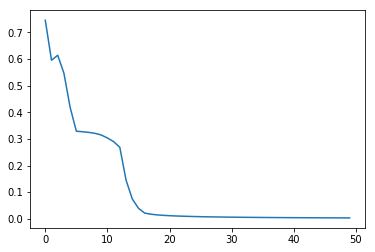

In [6]:
%matplotlib inline

losses = []
epochs = 50
for i_epoch in range(epochs):
#     print('======  EPOCH {}  ======'.format(i_epoch))
    epoch_losses = []
    for k in range(len(X)):
#         print('== Sample {} =========='.format(k))
        v = train_one(X[k], y[k], 0.2)
        epoch_losses.append(0.5*v['e']* v['e'])
        wGreenNeuron += v['update_green']
        wOrangeNeuron += v['update_orange']
        wOutputNeuron += v['update_out']
        pprint.pprint({'wGreenNeuron':wGreenNeuron, 'wOrangeNeuron':wOrangeNeuron, 'wOutputNeuron':wOutputNeuron})
        
    
    losses.append(np.mean(epoch_losses))
        
from matplotlib import pyplot as plt
plt.plot(list(range(epochs)), losses)
